Experimentos y ensayos en modelos de aprendizaje automático
===============================================================

## Introducción

El seguimiento (o tracking) de experimentos de aprendizaje automático es el proceso de organizar, registrar y analizar los resultados de los procesos de entrenamiento y evaluación de modelos. El objetivo es obtener información que pueda usarse para mejorar modelos futuros y tomar mejores decisiones sobre qué algoritmos y parámetros a usar.

### Beneficios

Hay muchos beneficios al usar herramientas de tracking de experimentos de aprendizaje automático, particularmente:

- Ayuda a comprender el rendimiento de los modelos.
- Ayuda a comparar differentes modelos y encontrar los hiperparámetros correctos.
- Posibilita la automatización de experimentos.
- Posibilita la reproducibilidad de los resultados.

![](https://github.com/santiagxf/E72102/blob/main/docs/develop/_images/tracking.png?raw=true)

### Conceptos

La mayoria de las herramientas de seguimiento utilizan 6 conceptos fundamentales:

- **Experimentos:** Representan el problema que queremos resolver. Los experimentos en general se identifican con un nombre y sirven de contenedor de todas las ejecuciones de nuestras iteraciones de aprendizaje automático.
- **Ensayos (runs o trials):** Es cada de la iteraciones dentro del proceso de desarrollo, incluyendo el proceso de preprocesamiento de datos, entrenamiento de modelos, y evaluación. En simples términos, cualquier operación que es necesaria para generar y/o evaluar nuestro modelo de aprendizaje automático se sucede dentro de un ensayo o ejecución.
- **Parámetros:** Representan cada uno de los valores que nuestro proceso de aprendizaje automático utiliza cómo configuración para el proceso de aprendizaje. Los hiperparámetros son casos típicos.
- **Métricas:** Representan cada una de las métricas que podemos utilizar para comparar o evaluar los resultados de la ejecución.
- **Modelos:** Representan cada uno de los modelos de aprendizaje automático que fueron generados durante la ejecución.
- **Artefactos:** Cualquier otro archivo que es generado como parte del proceso y que nos interesa mantener bajo control (source control) a los efectos de auditoria y reproducibilidad.

### Herramientas

Existen multiples herramientas en el mercado para el siguimiento de experimentos. Algunas de las más populares incluye:

**Herramientas incorporadas en nubes públicas:**

- Azure Machine Learning
- AWS SageMaker
- GCP Vertex AI

**Herramientas especificas:**

- MLflow (open-source).
- Weights & Biases
- Comet
- ClearML
- Neptune
- Guild AI
- Polyaxon

**Herramientas incorporadas en librarias:**

- Tensorboard (TensorFlow)

## Seguimiento del proceso de entrenando para el problema censo de la UCI

En este ejemplo, utilizaremos la herramienta Comet por el simple hecho de que es gratuita y tiene una curva de aprendizaje muy baja.

### Instalación

Para utilizar Comet en el seguimiento de experimentos, debemos instalar el paquete de Python que le da soporte:

In [1]:
%pip install comet_ml --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.4/558.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.1/510.1 kB 4.4 MB/s eta 0:00:00


Finalmente, instalemos las librerias que necesitamos para resolver nuestro problema:

In [2]:
!wget https://raw.githubusercontent.com/santiagxf/E72102/master/docs/develop/modeling/experimentation/code/tuning_bayesian.txt \
    --quiet --no-clobber
!pip install -r tuning_bayesian.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.8 MB/s eta 0:00:00


### Sobre el conjunto de datos del censo UCI

El conjunto de datos del censo de la UCI es un conjunto de datos en el que cada registro representa a una persona. Cada registro contiene 14 columnas que describen a una una sola persona, de la base de datos del censo de Estados Unidos de 1994. Esto incluye información como la edad, el estado civil y el nivel educativo. La tarea es determinar si una persona tiene un ingreso alto (definido como ganar más de $50 mil al año). Esta tarea, dado el tipo de datos que utiliza, se usa a menudo en el estudio de equidad, en parte debido a los atributos comprensibles del conjunto de datos, incluidos algunos que contienen tipos sensibles como la edad y el género, y en parte también porque comprende una tarea claramente del mundo real.

Descargamos el conjunto de datos

In [3]:
!wget https://santiagxf.blob.core.windows.net/public/datasets/uci_census.zip \
    --quiet --no-clobber
!mkdir -p datasets/uci_census
!unzip -qq uci_census.zip -d datasets/uci_census

Lo importamos

In [4]:
import pandas as pd
import numpy as np

train = pd.read_csv('datasets/uci_census/data/adult-train.csv')
test = pd.read_csv('datasets/uci_census/data/adult-test.csv')

### Configurando Comet en nuestro notebook

Comencemos configurando nuestro notebook para enviar toda la información de seguimiento a Comet.

1. Cree una cuenta de Comet gratuita: Dirijase a https://www.comet.com/login y cree una cuenta en la plataforma.
2. Cree un nuevo projecto donde incluir sus experimentos: Para ello, en el margen derecho de la pantalla verá la opción **New project**.
3. Los projectos solo necesitan un nombre para poder reconocerlos. Configure el projecto como **Experiment Tracking** y finalmente configure el nivel de visibilidad que quiere. En la mayoria de los casos utilizará **Private** pero si desea compartir su experimento con colegas, en la versión gratuita requerirá configurarlo como **Public**.
4. Necesitaremos también una forma de autenticar el código que ejecuta en el notebook para que pueda enviar la información a Comet. Esta comunicación se asegura utilizando un secreto o **key**. En la esquina superior derecha de la pantalla verá un botón con su nombre de usuario, haga click en el y seleccione **Account settings**.
5. En esta página, bajo la sección **API Keys**, copie el valor que se muestra. **No comparta este clave con nadie y asegurese de no incluirla en su código cuando lo distribuye**.


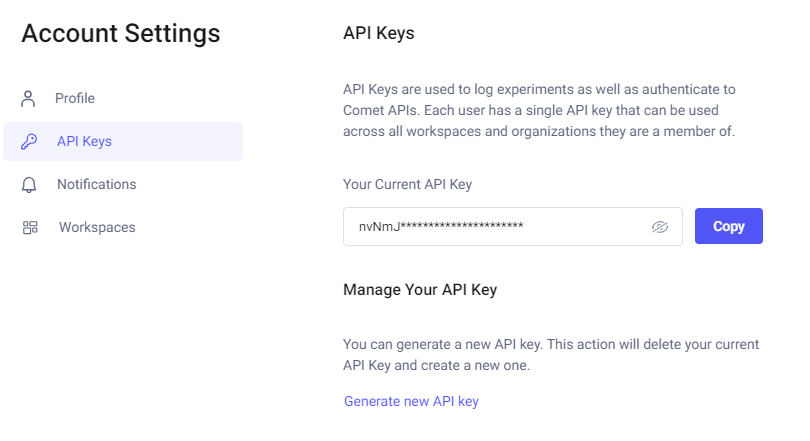

Utilizando esta información, ya tiene todo lo que necesita para configurar el notebook de la siguiente manera:

In [5]:
import comet_ml

In [6]:
comet_ml.init()

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


Una vez que la herramienta está configurada, podemos crear un experimento:

In [7]:
import comet_ml

experiment = comet_ml.Experiment(
    project_name = "uci-adults-income",
    workspace="santiagxf"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: You are trying to log string value as a metric. This is not recommended.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/santiagxf/uci-adults-income/066e3be264ea408395002f0a2f524357



A partir de este momento, Comet está monitoreando toda la actividad en este notebook. Comet tiene una funcionalidad de *autologging* lo cual hace que la actividad se registre automaticamente sin necesidad de escribir código especial.

Comet tiene integraciones con la librarias de código mas conocidas de ML, pero si en algún momento necesita trackear algo de forma especifica, la herramienta brinda formas de hacerlo.

### Creando el modelo

En este ejemplo, crearemos un modelo muy sencillo con el cual trabajar y demostrar como funciona.

Preparando nuestros conjuntos de datos:

In [8]:
X_train = train.drop(['income'], axis=1)
y_train = train['income'].to_numpy()
X_test = test.drop(['income'], axis=1)
y_test = test['income'].to_numpy()

In [9]:
classes = train['income'].unique().tolist()
features = X_train.columns.values.tolist()
categorical_features = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()

Realizaremos un pequeño preprocesamiento antes de entrenar el modelo:

- Imputaremos los valores faltantes de las caracteristicas numéricas con la media
- Imputaremos los valores faltantes de las caracteristicas categóricas con el valor `?`
- Escalaremos los valores numericos utilizando un `StandardScaler`
- Codificaremos las variables categóricas utilizando `OneHotEncoder`

In [10]:
from typing import Tuple, List

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def prepare(X: pd.DataFrame) -> Tuple[np.ndarray, sklearn.compose.ColumnTransformer]:
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }

    num_pipe = Pipeline([
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    transformations = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])
    X = transformations.fit_transform(X)

    return X, transformations


X_train_transformed, transformations = prepare(X_train)
X_test_transformed = transformations.transform(X_test)

Entrenamos un modelo basado en `lightgbm`

In [11]:
from lightgbm import LGBMClassifier

with experiment.train():
    clf = LGBMClassifier(n_estimators=5)
    model = clf.fit(X_train_transformed, y_train)

Podemos revisar la performance del modelo:

In [12]:
from sklearn.metrics import accuracy_score, recall_score

predictions = model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions, pos_label='>50K')

Este calculo que acabamos de realizar no queda registrado en Comet como una métrica. Si este valor es una métrica que nos interesa *grabar*, podermos logearla explicitamente:

In [13]:
with experiment.test():
  experiment.log_metric(name="accuracy", value=accuracy)
  experiment.log_metric(name="recall", value=recall)

Si quisieramos utilizar `classification_report`, podemos hacer algo como lo siguiente:

In [14]:
from sklearn.metrics import classification_report

with experiment.test():
    print(classification_report(y_test, predictions))
    for key, value in classification_report(y_test, predictions, output_dict=True).items():
        if key == "accuracy":
            experiment.log_metric(key, value)
        else:
            experiment.log_metrics(value, prefix=f"{key}")

              precision    recall  f1-score   support

       <=50K       0.81      1.00      0.90     12435
        >50K       0.98      0.25      0.40      3846

    accuracy                           0.82     16281
   macro avg       0.90      0.63      0.65     16281
weighted avg       0.85      0.82      0.78     16281



Podemos también persistir el modelo dentro del experimento. Para ello, primero lo guardamos en un archivo:

In [15]:
import cloudpickle

with open('model.pkl', 'wb') as f:
    cloudpickle.dump(model, f)

Luego utilizamos el método `log_model`:

In [16]:
experiment.log_model("classifier", "model.pkl")

{'web': 'https://www.comet.com/api/asset/download?assetId=3bd22b67abb4464ea2ffe41a07184ad6&experimentKey=066e3be264ea408395002f0a2f524357',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=3bd22b67abb4464ea2ffe41a07184ad6&experimentKey=066e3be264ea408395002f0a2f524357',
 'assetId': '3bd22b67abb4464ea2ffe41a07184ad6'}

### Finalizando la ejecución del experimento

En notebooks, es importante que finalicemos la ejecución para indicar a Comet que la ejecución del experimento ha finalizado.

In [17]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/santiagxf/uci-adults-income/066e3be264ea408395002f0a2f524357
COMET INFO:   Metrics:
COMET INFO:     test_<=50K_f1-score         : 0.8955966677485665
COMET INFO:     test_<=50K_precision        : 0.8118870145154963
COMET INFO:     test_<=50K_recall           : 0.9985524728588661
COMET INFO:     test_<=50K_support          : 12435
COMET INFO:     test_>50K_f1-score          : 0.4009931719428926
COMET INFO:     test_>50K_precision         : 0.9817629179331308
COMET INFO:     test_>50K_recall            : 0.25195007800312014
COMET INFO:     test_>50K_support           : 3846
COMET INFO:     test_accuracy               : 0.8221853694

Dirijase a Comet y verá todos estos resultados dentro de la plataforma.